# Assiciation rules

## 1.0 - Imports

In [1]:
import pandas as pd
import numpy as np

# Only to use on jupyter notebook
from IPython.display import display, HTML

import seaborn as sns
import matplotlib.pylab as plt

from apyori import apriori
from mlxtend.preprocessing import TransactionEncoder

In [2]:
def jupyter_settings():  
    
    # show the charts at jupyter cell
    %matplotlib inline
    
    # Matplotlib style and size patterns
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 20
    
    # Dataframe control showded
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    # Vizualization expanded to 95% of screen
    display(HTML('<style>.conteiner{width:95% !important;}</style>'))

    # Apply into seaborn
    sns.set()

    
# Function Called
jupyter_settings()

## 2.0 - Data Extraction

In [3]:
df = pd.read_csv('../dataset/census.csv')

## 3.0 - Data Understanding

### 3.1 - Describing data

In [4]:
df.shape

(32561, 15)

In [154]:
desc = (
    pd.concat(
        [
            df.dtypes,
            df.isna().sum(),
            df.nunique(),
            df.min(),
            df.max(),
            df.mean().round(),
            df.std().round(),
            df.sample(3).T
        ]
    , axis=1)
)
desc.columns = [
    'dtypes', 'null_value', 'unique', 
    'min', 'max', 'mean', 'std', 0, 1, 2
]
desc

/tmp/ipykernel_9640/1093006105.py:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.mean().round(),
/tmp/ipykernel_9640/1093006105.py:10: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.std().round(),


,dtypes,null_value,unique,min,max,mean,std,0,1,2
age,int64,0,73,17,90,39.0,14.0,27,30,20
workclass,object,0,9,?,Without-pay,NaN,NaN,Private,Self-emp-not-inc,Private
final-weight,int64,0,21648,12285,1484705,189778.0,105550.0,133425,404062,249543
education,object,0,16,10th,Some-college,NaN,NaN,HS-grad,HS-grad,Some-college
education-num,int64,0,16,1,16,10.0,3.0,9,9,10
marital-status,object,0,7,Divorced,Widowed,NaN,NaN,Never-married,Married-civ-spouse,Never-married
occupation,object,0,15,?,Transport-moving,NaN,NaN,Exec-managerial,Prof-specialty,Protective-serv
relationship,object,0,6,Husband,Wife,NaN,NaN,Not-in-family,Husband,Own-child
race,object,0,5,Amer-Indian-Eskimo,White,NaN,NaN,White,White,White
sex,object,0,2,Female,Male,NaN,NaN,Female,Male,Female


* Dont have null values
* capital gain an loos haven't enough examples, it'll be deleted
* `age`, `final-weight`, `hour-per-week`
* `education-num` it'll change the data types to category

In [155]:
df = df.drop(['capital-gain', 'capital-loos'], axis=1).copy()

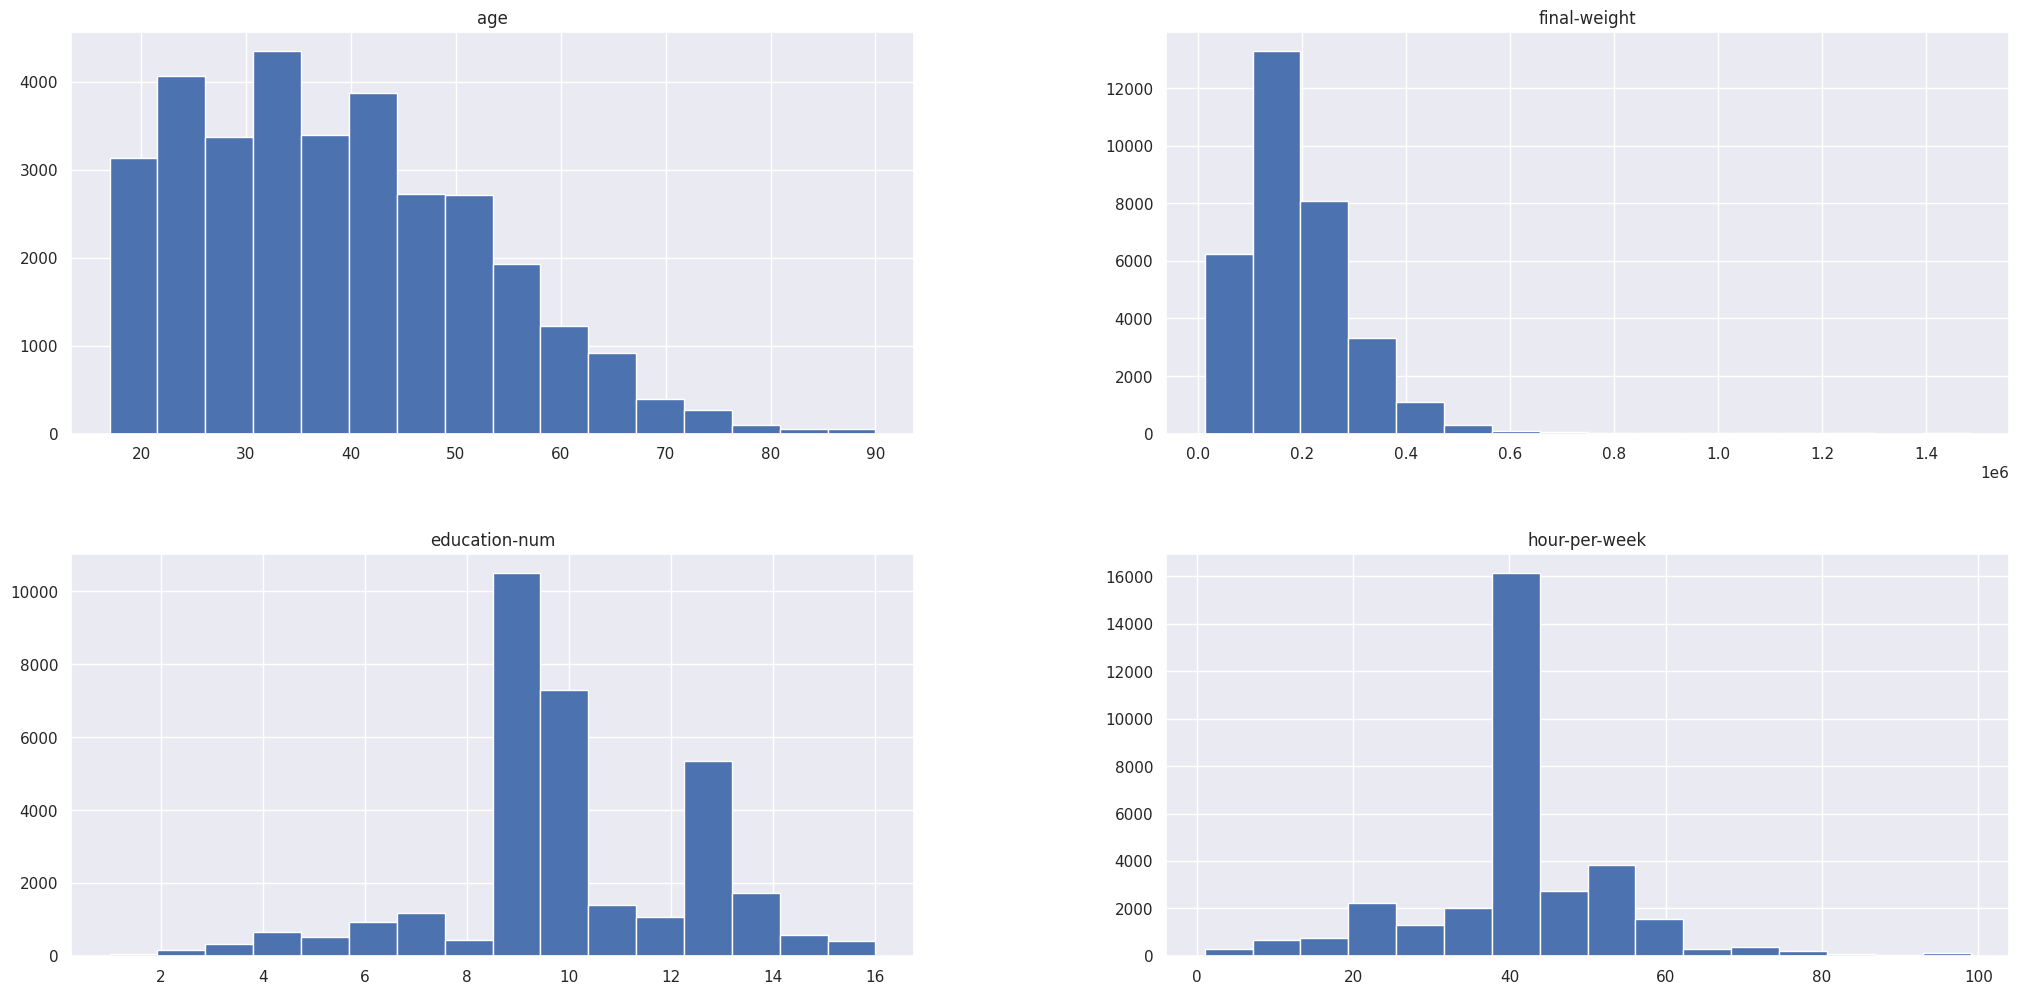

In [156]:
df.hist(bins=16);

### 3.2 - `age`

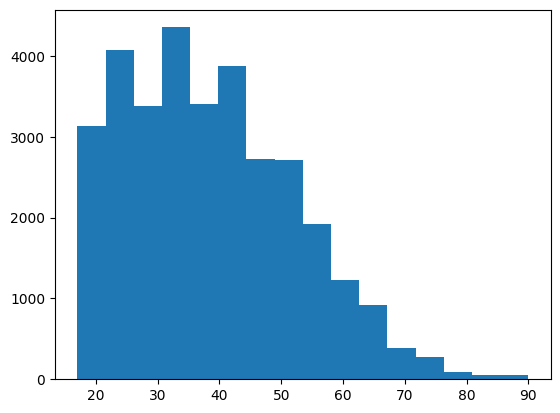

In [19]:
plt.hist(data=df, x='age', bins='sturges');

Let's cut the numeric values to categorical by range each 10 (10,20,30...)

In [22]:
pd.cut(df['age'], bins=[df['age'].min(),20,30,40, 50, 60, df['age'].max()]).value_counts()

(30, 40]    8546
(20, 30]    8162
(40, 50]    6983
(50, 60]    4128
(60, 90]    2332
(17, 20]    2015
Name: age, dtype: int64

### 3.3 - `final-weight`

In [42]:
fw_min = df['final-weight'].min()
fw_max = df['final-weight'].max()

# calculating sturges to get the interval values
aa = fw_max - fw_min
i = int(1+3.3*np.log10(df.shape[0]))

pd.cut(
    x=df['final-weight'], 
    bins=i
    ).value_counts()

(110446.333, 208607.667]      14441
(10812.58, 110446.333]         7031
(208607.667, 306769.0]         6972
(306769.0, 404930.333]         2946
(404930.333, 503091.667]        810
(503091.667, 601253.0]          219
(601253.0, 699414.333]           78
(699414.333, 797575.667]         34
(797575.667, 895737.0]           10
(895737.0, 993898.333]            7
(993898.333, 1092059.667]         4
(1092059.667, 1190221.0]          4
(1190221.0, 1288382.333]          2
(1386543.667, 1484705.0]          2
(1288382.333, 1386543.667]        1
Name: final-weight, dtype: int64

After calculating sturges and see the distribution above, I decided get the manual values by stuges but concanate >699414 to reduce the classes

In [44]:
range_list = [fw_min, 110446, 208607, 306769, 404930, 503091, 601253, fw_max]

pd.cut(
    x=df['final-weight'], 
    bins=range_list
    ).value_counts()

(110446, 208607]     14441
(12285, 110446]       7030
(208607, 306769]      6972
(306769, 404930]      2946
(404930, 503091]       810
(503091, 601253]       219
(601253, 1484705]      142
Name: final-weight, dtype: int64

### 3.4 - `hour-per-week`

In [11]:
# calculanting sturges to get a count of classes
i = 1+3.3*np.log10(df.shape[0])
i.round()

16.0

<AxesSubplot: >

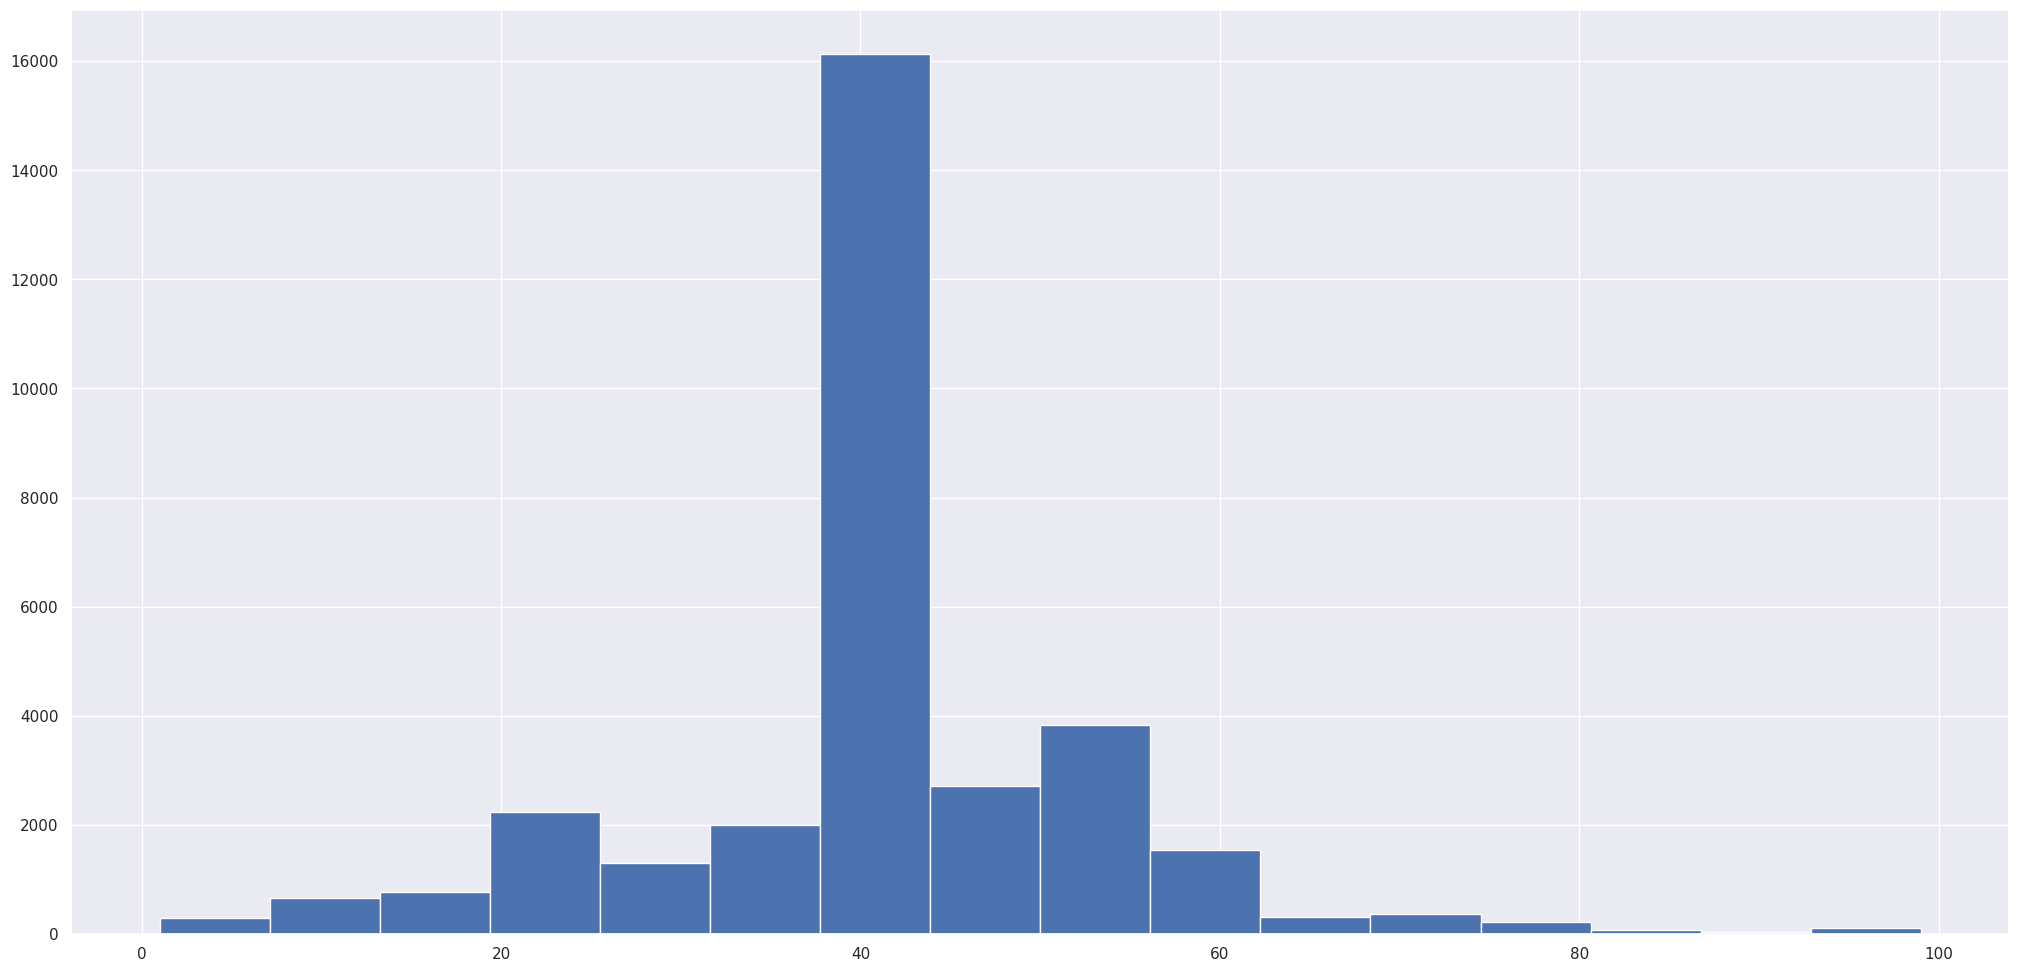

In [12]:
df['hour-per-week'].hist(bins=16)

In [14]:
pd.cut(x=df['hour-per-week'], bins=16).value_counts()

(37.75, 43.875]    16137
(43.875, 50.0]      5532
(19.375, 25.5]      2239
(31.625, 37.75]     1999
(56.125, 62.25]     1545
(25.5, 31.625]      1307
(50.0, 56.125]      1008
(13.25, 19.375]      761
(7.125, 13.25]       648
(68.375, 74.5]       365
(62.25, 68.375]      301
(0.902, 7.125]       295
(74.5, 80.625]       216
(92.875, 99.0]       106
(80.625, 86.75]       64
(86.75, 92.875]       38
Name: hour-per-week, dtype: int64

In [26]:
range_list = [0, 13, 19, 25, 31, 37, 44, 50, 56, 62, df['hour-per-week'].max()]
pd.cut(x=df['hour-per-week'], bins=range_list).value_counts()

(37, 44]    16349
(44, 50]     5320
(19, 25]     2239
(31, 37]     1999
(56, 62]     1545
(25, 31]     1307
(62, 99]     1090
(50, 56]     1008
(0, 13]       943
(13, 19]      761
Name: hour-per-week, dtype: int64

### 3.5 - `education-num`

In [51]:
df['education-num'].astype('category').dtypes

CategoricalDtype(categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], ordered=False)

## 4.0 - Data Cleaning

In [4]:

def drop_features(data):
    
    data = data.drop(['capital-gain', 'capital-loos'], axis=1).copy()
    
    return data


def change_datatype(data):

    '''
        Action:
            Change the type of data
    '''
    
    data['education-num'] = data['education-num'].astype('category')

    return data

In [5]:
df = drop_features(df)
df = change_datatype(df)

## 5.0 - Data Transformation

In [6]:
def binning_feature(data):

    '''
        Transforming numeric to categorical features.

        The method used to cut classes was the Sturges's calculous
        and empirical business knowledge after the interval range defined
        it will get the discrete or continuous columns 
        and converting to categorical values.
    '''

    # Age column
    data['age'] = pd.cut(
        data['age'], bins=[data['age'].min(),20,30,40, 50, 60, data['age'].max()]
    )

    # final-weight column
    fw_min, fw_max= data['final-weight'].min(), data['final-weight'].max()
    range_list = [fw_min, 110446, 208607, 306769, 404930, 503091, 601253, fw_max]
    data['final-weight'] = pd.cut(
        x=data['final-weight'], 
        bins=range_list
    )

    range_list = [0, 13, 19, 25, 31, 37, 44, 50, 56, 62, data['hour-per-week'].max()]
    data['hour-per-week'] = pd.cut(x=data['hour-per-week'], bins=range_list)
    
    return data

In [7]:
df = binning_feature(df)

## 6.0 - Data Selection

## 7.0 - Modeling

In [47]:
pred = apriori(df, min_support=0.4, min_confidence=0.8)

In [48]:
ra = list(pred)

In [51]:
[row for row in ra[0]]

[frozenset({'a', 'c'}),
 0.46153846153846156,
 [OrderedStatistic(items_base=frozenset({'c'}), items_add=frozenset({'a'}), confidence=0.8571428571428572, lift=1.1142857142857143)]]